# Created the ConvNet baseline model before any transfer learning

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import os

In [2]:
data_root = '.'
train = pd.read_csv(os.path.join(data_root, "train.csv"))
test = pd.read_csv(os.path.join(data_root, "test.csv"))
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3215 entries, 0 to 3214
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  3215 non-null   object
 1   label     3215 non-null   object
dtypes: object(2)
memory usage: 50.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732 entries, 0 to 1731
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  1732 non-null   object
dtypes: object(1)
memory usage: 13.7+ KB


(None, None)

In [3]:
train_img_path = os.path.join(data_root, 'train_img')
test_img_path = os.path.join(data_root, 'test_img')
os.listdir(train_img_path)[:5]

['train_445a.png',
 'train_432c.png',
 'train_275b.png',
 'train_653d.png',
 'train_625b.png']

In [4]:
# train.label.unique()
label_map = {name: i for i, name in enumerate(train.label.unique())}
unlabel_map = {i: name for i, name in enumerate(train.label.unique())}
label_map, unlabel_map

({'rice': 0,
  'candy': 1,
  'jam': 2,
  'coffee': 3,
  'vinegar': 4,
  'chocolate': 5,
  'sugar': 6,
  'water': 7,
  'juice': 8,
  'milk': 9,
  'soda': 10,
  'nuts': 11,
  'chips': 12,
  'spices': 13,
  'cereal': 14,
  'beans': 15,
  'cake': 16,
  'honey': 17,
  'flour': 18,
  'pasta': 19,
  'tomatosauce': 20,
  'tea': 21,
  'corn': 22,
  'oil': 23,
  'fish': 24},
 {0: 'rice',
  1: 'candy',
  2: 'jam',
  3: 'coffee',
  4: 'vinegar',
  5: 'chocolate',
  6: 'sugar',
  7: 'water',
  8: 'juice',
  9: 'milk',
  10: 'soda',
  11: 'nuts',
  12: 'chips',
  13: 'spices',
  14: 'cereal',
  15: 'beans',
  16: 'cake',
  17: 'honey',
  18: 'flour',
  19: 'pasta',
  20: 'tomatosauce',
  21: 'tea',
  22: 'corn',
  23: 'oil',
  24: 'fish'})

# Custom dataset

In [5]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class ProductDataset(Dataset):
    def __init__(self, label_data: pd, img_dir, transform=None, train_flag = False):
        self.img_labels = label_data
        self.img_dir = img_dir
        self.transform = transform
        self.train_flag = train_flag
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0] + '.png')
        image = Image.open(img_path)
        
        processed_label = -1  # Place holder value.
        if self.train_flag:
            raw_label = self.img_labels.iloc[idx, 1]
            processed_label = label_map[raw_label]
            
        if self.transform:
            image = self.transform(image)
        return image, processed_label

preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

trainset = ProductDataset(train, train_img_path, transform=preprocess, train_flag=True)
testset = ProductDataset(test, test_img_path, transform=preprocess)

# Testing dataloader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0474076].


torch.Size([4, 3, 299, 299])
tensor([18, 14, 13, 18])
torch.Size([299, 299, 3])


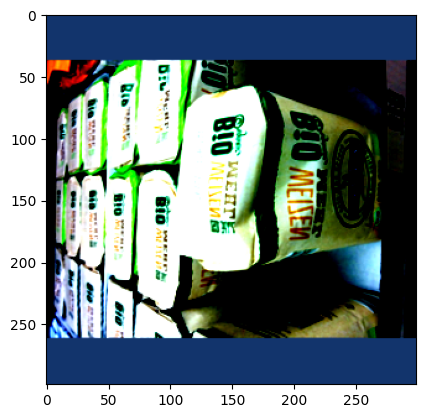

Label: 18
Product Name: flour


In [6]:
batch_size = 4
n = int(0.7 * len(os.listdir(train_img_path)))

train_loader = DataLoader(trainset, batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size, shuffle=True)

train_features, train_labels = next(iter(train_loader))
print(train_features.size())
print(train_labels)


img = train_features[0].transpose(-3, -1)
print(img.shape)
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")
print(f"Product Name: {unlabel_map[int(label)]}")


## Baseline model and test the model

In [8]:
import torch.nn as nn
import torch.nn.functional as F


class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2= nn.Conv2d(32, 64, 3, 1, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2, 0)
        self.fc1 = nn.Linear(128 * 37 * 37, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 25)           # 25 labels for classification
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 37 * 37)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

model = ConvNet()
model.to(device)
sample_input = torch.randn(4, 3, 299, 299)
output = model(sample_input.to(device))
output.shape

Using mps device


torch.Size([4, 25])

## Training loop

In [15]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer):
    model.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(images)

        # For debug
        if i % 100 == 0:
            print(f"{i}-th set is done")
        
        loss = nn.functional.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'loss: {running_loss / len(train_loader):.3f}')

In [26]:
import torch.optim as optim
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler

lr = 1e-2
k_folds = 5
batch_size = 4
epochs = 1
best_loss = None
EARLY_STOPPING = True


device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

kf = KFold(n_splits=k_folds, shuffle=True)


for fold, (train_idx, val_idx) in enumerate(kf.split(trainset)):
    print(f"Fold{fold + 1}")
    print("------")
    
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loader = DataLoader(
        trainset,
        batch_size,
        sampler=SubsetRandomSampler(train_idx)
    )
    
    val_loader = DataLoader(
        trainset,
        batch_size,
        sampler=SubsetRandomSampler(val_idx)
    )

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for i, (images, labels) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()

            outputs = model(images)

            # # For debug
            # if i % 100 == 0:
            #     print(f"{i}-th set is done")
            
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'loss: {running_loss / len(train_loader):.3f}')
    print('Finished Training, proceed to the evaluation.')
    
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
                    
            output = model(images)
            val_loss += F.cross_entropy(output, labels).item()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()
    
    val_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    print(f"Test set: Average loss: {val_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n")
    
    # Save the best model
    if best_loss is None or val_loss < best_loss:
        best_loss = val_loss
        print(f'epoch: {epoch}, best loss updated to {val_loss:.6f}')
        fname = f'{data_root}/best_model_fold-{fold}.pt'
        torch.save(model.state_dict(), fname)

    

Using mps device
Fold1
------


loss: 3.161
Finished Training, proceed to the evaluation.
Test set: Average loss: 0.2950, Accuracy: 47/1732 (2.71%)

epoch: 0, best loss updated to 0.295001
Fold2
------


loss: 3.160
Finished Training, proceed to the evaluation.
Test set: Average loss: 0.2946, Accuracy: 45/1732 (2.60%)

epoch: 0, best loss updated to 0.294598
Fold3
------


loss: 3.163
Finished Training, proceed to the evaluation.
Test set: Average loss: 0.2937, Accuracy: 46/1732 (2.66%)

epoch: 0, best loss updated to 0.293711
Fold4
------


loss: 3.173
Finished Training, proceed to the evaluation.
Test set: Average loss: 0.2904, Accuracy: 63/1732 (3.64%)

epoch: 0, best loss updated to 0.290382
Fold5
------


loss: 3.158
Finished Training, proceed to the evaluation.
Test set: Average loss: 0.2960, Accuracy: 41/1732 (2.37%)



# Load the best model

In [27]:
import glob
model_path = f'{data_root}/best_model_fold-3.pt'
model.load_state_dict(torch.load(model_path))

/var/folders/fl/vtht_j7j6dqfpc3lzlwjsxm80000gp/T/ipykernel_49819/941575893.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

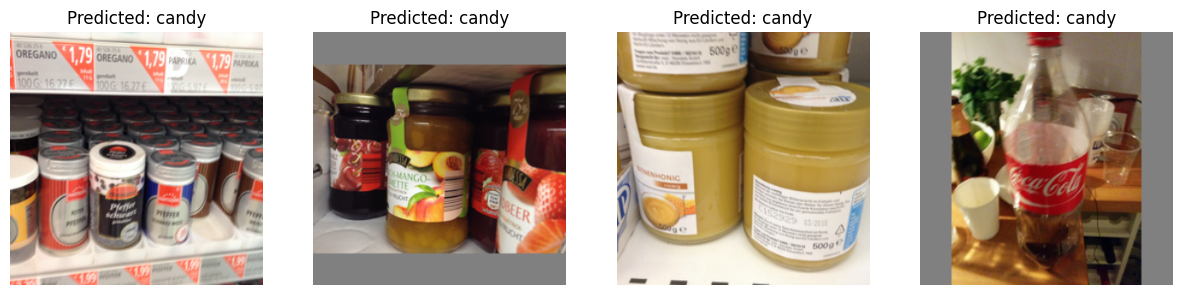

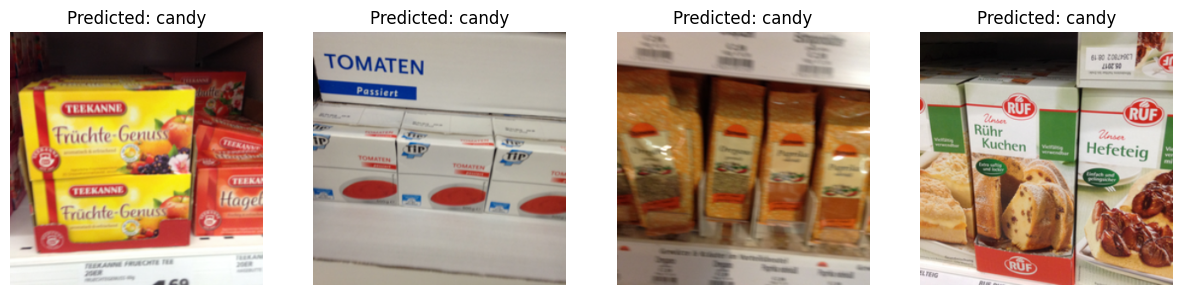

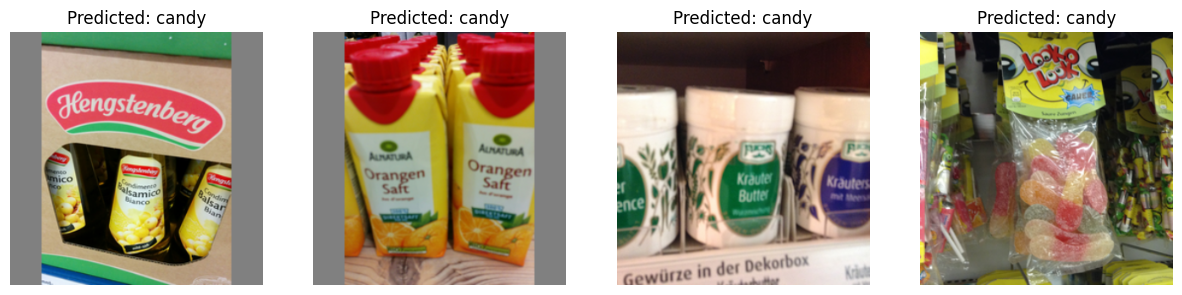

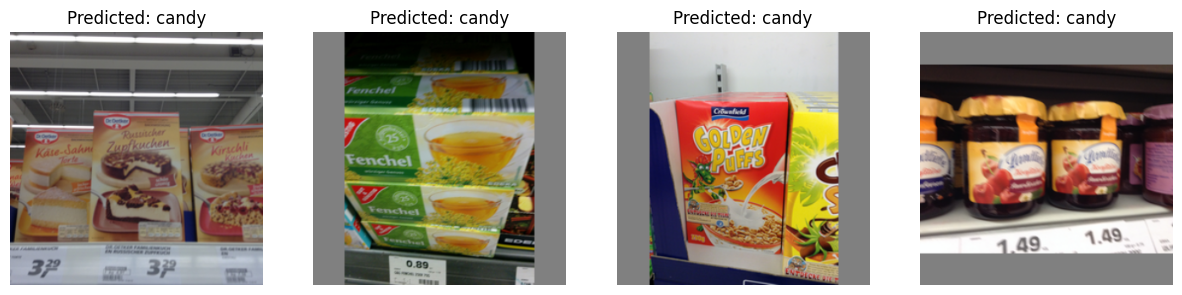

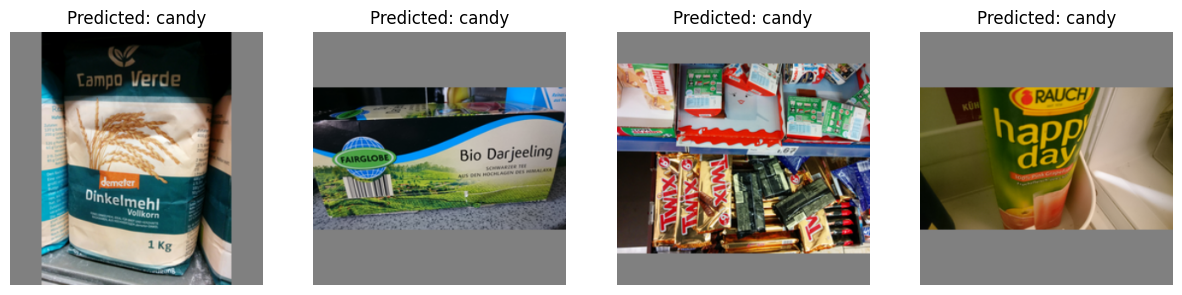

In [28]:
model.eval()

with torch.no_grad():
    for i, (data, label) in enumerate(test_loader):        
        output = model(data.to(device))
        # Extract the predicted labels
        _, indices = torch.max(output, 1)
        
        if i % 100 == 0:
            # Display the first n images in the batch (e.g., 4 images)
            n = min(len(data), 4)  # Number of images to display
            fig, axs = plt.subplots(1, n, figsize=(15, 5))
            
            for j in range(n):
                image = data[j].cpu().numpy().transpose((1, 2, 0))  # Convert from CHW to HWC

                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                image = std * image + mean
                image = np.clip(image, 0, 1)

                # Display the image
                axs[j].imshow(image)
                axs[j].set_title(f"Predicted: {unlabel_map[int(indices[j])]}")
                axs[j].axis('off')

            plt.show()